## 0. 实验介绍

基于**LSTM**模型预测未来一个交易日的涨跌。

## 1. 数据预处理
### 1.1 根据股票代码划分数据
* 训练集

In [1]:
cols = [0,1,2,3,4,6,7,8,9,10,14]

In [2]:
import pandas as pd

df = pd.read_csv("./data/train.csv", usecols=cols)
stocks_code = df["kdcode"].unique()
stock_num = len(stocks_code)

print(stocks_code)
stock_num

['000001.SZ' '000157.SZ' '000333.SZ' '000568.SZ' '000703.SZ' '000768.SZ'
 '002024.SZ' '002044.SZ' '002049.SZ' '002120.SZ' '002230.SZ' '002271.SZ'
 '002311.SZ' '002371.SZ' '002456.SZ' '002602.SZ' '002607.SZ' '002714.SZ'
 '002773.SZ' '300003.SZ' '300033.SZ' '300124.SZ' '300144.SZ' '300628.SZ'
 '600000.SH' '600009.SH' '600016.SH' '600019.SH' '600025.SH' '600028.SH'
 '600030.SH' '600031.SH' '600036.SH' '600048.SH' '600050.SH' '600061.SH'
 '600104.SH' '600115.SH' '600196.SH' '600276.SH' '600309.SH' '600340.SH'
 '600383.SH' '600489.SH' '600519.SH' '600547.SH' '600570.SH' '600585.SH'
 '600588.SH' '600690.SH' '600703.SH' '600745.SH' '600809.SH' '600837.SH'
 '600848.SH' '600886.SH' '600887.SH' '600926.SH' '600958.SH' '601006.SH'
 '601088.SH' '601166.SH' '601169.SH' '601238.SH' '601318.SH' '601319.SH'
 '601336.SH' '601398.SH' '601555.SH' '601601.SH' '601628.SH' '601788.SH'
 '601838.SH' '601857.SH' '601872.SH' '601899.SH' '601919.SH' '601990.SH'
 '601998.SH' '603233.SH' '603799.SH' '603833.SH']


82

In [3]:
# 根据股票代码划分数据
for i, stock_i in enumerate(stocks_code):
    stock_i_data = df[df['kdcode'].isin([stock_i])]
    exec("train_df%s = stock_i_data" % i)

* 测试集

In [4]:
df2 = pd.read_csv("./data/test.csv", usecols=cols)
stocks_code2 = df2["kdcode"].unique()

# 根据股票代码划分数据
for i, stock_i in enumerate(stocks_code2):
    stock_i_data = df2[df2['kdcode'].isin([stock_i])]
    exec("test_df%s = stock_i_data" % i)

共82支股票

训练集按股票分为`train_df0`~`train_df81`

测试集按股票分为`test_df0`~`test_df81`

### 1.2 将原始数据改造为LSTM网络的输入

In [5]:
feanum=8 # 一共有多少特征
window=7 # 时间窗设置

分割出window个时间窗的数据为输入的`X`

紧接着的那条数据为标签`Y`

因此需要将每只股票的数据按照时间(日期)分割成`window + 1`长度的数据

In [6]:
import numpy as np

trainResult = []
for i in range(stock_num): # 遍历训练集所有股票的DataFrame
    exec("trainData = train_df%s.values" % i)
    sequence_length = window + 1
    trainData = trainData[:,2:] # 去除股票代码、日期两字段
    for index in range(len(trainData) - sequence_length + 1):
        trainResult.append(trainData[index: index + sequence_length])

trainResult = np.array(trainResult)
trainResult.shape

(73987, 8, 9)

In [7]:
testResult = []
for i in range(stock_num): # 遍历训练集所有股票的DataFrame
    exec("testData = test_df%s.values" % i)
    sequence_length = window + 1
    testData = testData[:,2:] # 去除股票代码、日期两字段
    for index in range(len(testData) - sequence_length + 1):
        testResult.append(testData[index: index + sequence_length])

testResult = np.array(testResult)
testResult.shape

(19331, 8, 9)

分割`X`, `Y`

In [8]:
X_train = trainResult[:, :-1, :-1]
X_test = testResult[:, :-1, :-1]

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

print("训练集X：" + str(X_train.shape))
print("测试集X：" + str(X_test.shape))

# X_train[0: 5]

训练集X：(73987, 7, 8)
测试集X：(19331, 7, 8)


处理数据的Y

涨为`1`,跌为`0`

In [9]:
Y_train = trainResult[:, window, -1]
Y_train.shape

(73987,)

In [10]:
Y_test = testResult[:, window, -1]
Y_test.shape

(19331,)

In [11]:
Y_train = Y_train.astype('float64')
Y_test = Y_test.astype('float64')
# Y_train[0:5]
# Y_test[0:5]

## 2. 模型构建与训练

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import GRU
from keras.callbacks import EarlyStopping

#建立、训练模型过程
d = 0.2
model = Sequential()#建立层次模型
model.add(LSTM(32, input_shape=(window, feanum), return_sequences=False))#建立LSTM层
model.add(Dropout(d))#建立的遗忘层

model.add(Dense(16,kernel_initializer='uniform',activation='relu'))   #建立全连接层     
model.add(Dense(1, kernel_initializer = "uniform", activation = "sigmoid"))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs = 120, batch_size = 256) #训练模型epochs次

Epoch 1/120
290/290 [==============================] - 1s 4ms/step - loss: 0.6930 - accuracy: 0.5101
Epoch 2/120
290/290 [==============================] - 1s 4ms/step - loss: 0.6929 - accuracy: 0.5110
Epoch 3/120
290/290 [==============================] - 1s 4ms/step - loss: 0.6928 - accuracy: 0.5111
Epoch 4/120
290/290 [==============================] - 1s 4ms/step - loss: 0.6927 - accuracy: 0.5124
Epoch 5/120
290/290 [==============================] - 1s 4ms/step - loss: 0.6928 - accuracy: 0.5127
Epoch 6/120
290/290 [==============================] - 1s 4ms/step - loss: 0.6927 - accuracy: 0.5127
Epoch 7/120
290/290 [==============================] - 1s 4ms/step - loss: 0.6926 - accuracy: 0.5122
Epoch 8/120
290/290 [==============================] - 1s 4ms/step - loss: 0.6928 - accuracy: 0.5071
Epoch 9/120
290/290 [==============================] - 1s 4ms/step - loss: 0.6926 - accuracy: 0.5120
Epoch 10/120
290/290 [==============================] - 1s 4ms/step - loss: 0.6925 - accura

In [13]:
#总结模型
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5248      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 5,793
Trainable params: 5,793
Non-trainable params: 0
_________________________________________________________________


## 3. 模型训练结果
* 训练集

In [14]:
#在训练集上的拟合结果
Y_train_predict=model.predict(X_train)[:,0]
Y_train = Y_train

Text(0.5, 1.0, 'Train Data')

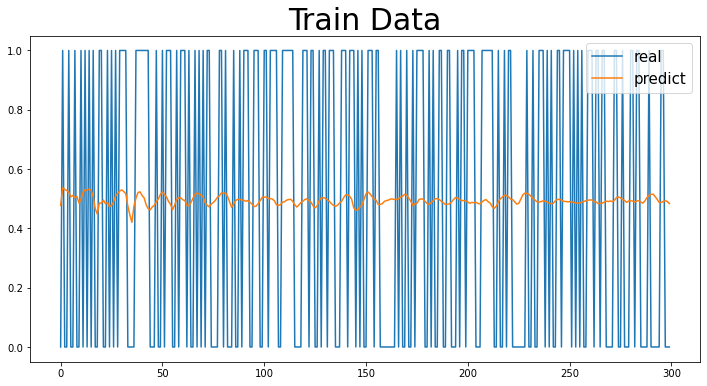

In [15]:
import matplotlib.pyplot as plt

draw=pd.concat([pd.DataFrame(Y_train),pd.DataFrame(Y_train_predict)],axis=1)
draw.iloc[:300,0].plot(figsize=(12,6))
draw.iloc[:300,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题
#展示在训练集上的表现 

* 测试集

In [16]:
#在测试集上的预测
Y_test_predict=model.predict(X_test)[:,0]
Y_test=Y_test

Text(0.5, 1.0, 'Test Data')

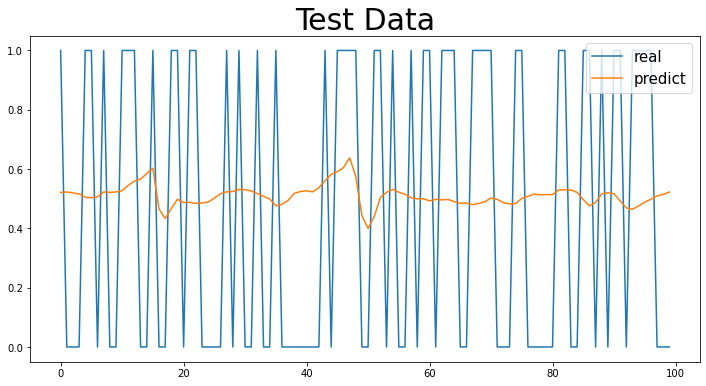

In [17]:
draw=pd.concat([pd.DataFrame(Y_test),pd.DataFrame(Y_test_predict)],axis=1);
draw.iloc[:100,0].plot(figsize=(12,6))
draw.iloc[:100,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题
# 展示在测试集上的表现 

In [18]:
txt = np.zeros(len(Y_test))
test_predict = Y_test_predict.copy()
test_predict[Y_test_predict > 0.5] = 1
test_predict[Y_test_predict <= 0.5] = 0

train_predict = Y_train_predict.copy()
train_predict[Y_train_predict > 0.5] = 1
train_predict[Y_train_predict <= 0.5] = 0

result = metrics.accuracy_score(Y_test, test_predict)
print('预测涨跌正确:',result)

预测涨跌正确: 0.5334954218612591


* 训练过程Loss,Accuracy的变化

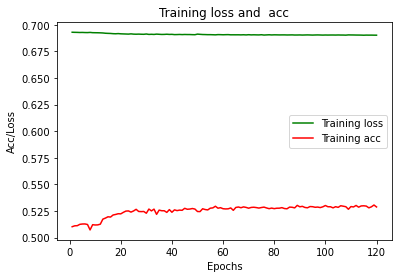

In [19]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, acc, 'r', label='Training acc')  
plt.title('Training loss and  acc')
plt.xlabel('Epochs')
plt.ylabel('Acc/Loss')
plt.legend()

* ROC曲线以及AUC值

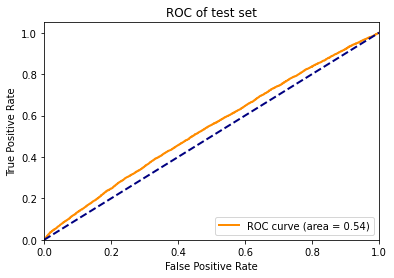

In [20]:
# 测试集
Y_test
Y_test_predict
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_predict, pos_label=1)
# print("fpr",fpr)
# print("tpr",tpr)
# print("thresholds",thresholds)
auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of test set')
plt.legend(loc="lower right")
plt.show()

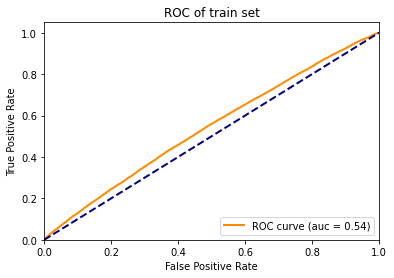

In [21]:
# 训练集
fpr, tpr, thresholds = metrics.roc_curve(Y_train, Y_train_predict, pos_label=1)
# print("fpr",fpr)
# print("tpr",tpr)
# print("thresholds",thresholds)
auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (auc = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of train set')
plt.legend(loc="lower right")
plt.show()

* f1-score

In [22]:
print(metrics.f1_score(Y_train, train_predict))
print(metrics.f1_score(Y_test, test_predict))

0.42489447984771994
0.44319585082736473


## 4. 保存模型

In [23]:
model.save('./models/lstm_model_test.h5')